## Model for the Gender classification problem Using the public dataset

### Extract and label the dataset

In [1]:
import os
from keras.preprocessing.image import load_img, img_to_array

def extract_dataset(main_folder, image_size=(48, 48)):
    train_dataset = []
    train_labels = []
    val_dataset = []
    val_labels = []

    # Define a dictionary to map each emotion to a unique label
    emotion_labels = {'Female': 0, 'Male': 1}

    # Loop through emotions in the main folder
    for emotion in emotion_labels:
        train_folder = os.path.join(main_folder, 'Training', emotion)
        val_folder = os.path.join(main_folder, 'Validation', emotion)
        label = emotion_labels[emotion]

        # Training set
        for filename in os.listdir(train_folder):
            if filename.endswith(('.jpg', '.jpeg', '.png', '.JPG')):  
                image_path = os.path.join(train_folder, filename)

                # Load the image using TensorFlow and convert to grayscale
                img = load_img(image_path, color_mode='grayscale', target_size=image_size)
                img_array = img_to_array(img)

                # Normalize the pixel values to the range [0, 1]
                img_array /= 255.0

                # Append the image data and label to the training dataset
                train_dataset.append(img_array)
                train_labels.append(label)

        # Validation set
        for filename in os.listdir(val_folder):
            if filename.endswith(('.jpg', '.jpeg', '.png', '.JPG')):  
                image_path = os.path.join(val_folder, filename)

                # Load the image using TensorFlow and convert to grayscale
                img = load_img(image_path, color_mode='grayscale', target_size=image_size)
                img_array = img_to_array(img)

                # Normalize the pixel values to the range [0, 1]
                img_array /= 255.0

                # Append the image data to the validation dataset
                val_dataset.append(img_array)
                val_labels.append(label)

    return train_dataset, train_labels, val_dataset, val_labels


In [2]:
main_folder_path = 'DATA2'  

train_dataset, train_labels, val_dataset, val_labels = extract_dataset(main_folder_path)



print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))

Number of training samples: 47009
Number of validation samples: 11649


In [3]:
import random
import matplotlib.pyplot as plt
import numpy as np

def plot_random_samples(train_data, train_labels, emotion_labels, num_samples=10):
    # Get unique labels
    unique_labels = np.unique(train_labels)

    # Set up subplots
    num_classes = len(unique_labels)
    fig, axs = plt.subplots(num_classes, num_samples, figsize=(num_samples, num_classes))

    # Iterate through each class
    for i, label in enumerate(unique_labels):
        # Get indices of samples with the current label
        indices = [idx for idx, l in enumerate(train_labels) if l == label]

        # Randomly select num_samples indices
        selected_indices = random.sample(indices, min(num_samples, len(indices)))

        # Plot the selected samples for the current class
        for j, idx in enumerate(selected_indices):
            axs[i, j].imshow(train_data[idx][:, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title(emotion_labels[label])

    plt.show()

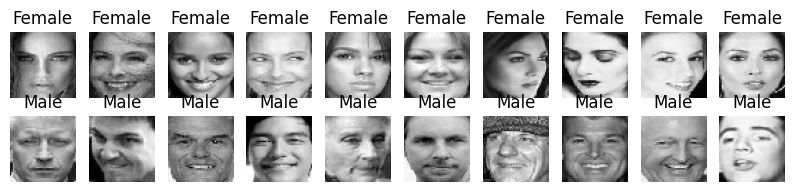

In [4]:
emotion_labels = {0: 'Female', 1: 'Male'}
plot_random_samples(train_dataset, train_labels, emotion_labels)

In [5]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np

In [6]:
# Define the VGGNet16 model
def create_vggnet16_model(input_shape=(48, 48, 1)):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(2, activation='softmax'))
    model.summary()
    return model

In [7]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    
    # Get unique classes from the data
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues', values_format='d')

    # Update tick locations based on unique classes
    plt.xticks(np.arange(len(unique_classes)), unique_classes, rotation=45)
    plt.yticks(np.arange(len(unique_classes)), unique_classes)
    
    plt.show()

In [8]:
def plot_accuracy_curves(history):
    # Plot train accuracy and validation accuracy over epochs
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training Vs Validation Accuracy')
    plt.show()

In [9]:
def plot_loss_curves(history):
    # Plot train loss and validation loss over epochs
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Vs Validation Loss')
    plt.show()

In [10]:
def train_vgg(dataset, labels, learning_rate=0.001, batch_size=32, test_size=0.2, epochs=10, patience=3):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=test_size, random_state=42)

    # Compute class weights
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)
    # Create and compile the VGGNet16 model
    model = create_vggnet16_model()
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Train the model with class weights
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(np.array(val_dataset),np.array(val_labels)),
                        callbacks=[early_stopping],class_weight=class_weight_dict)

    # Print test loss, test accuracy, train loss, train accuracy
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    train_loss, train_accuracy = model.evaluate(X_train, y_train)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    
    plot_accuracy_curves(history)
    plot_loss_curves(history)
    
    # Predict on test set
    y_pred = model.predict(X_test)

    # Convert predictions to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Get class names
    class_names = ['Female','Male']

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred_classes, target_names=class_names))
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred_classes, classes=class_names)
    return model

In [11]:
import psutil
print("Memory Usage Before:", psutil.virtual_memory())

Memory Usage Before: svmem(total=14877257728, available=3518537728, percent=76.3, used=11358720000, free=3518537728)


{0: 1.0112506991352235, 1: 0.9889968863081713}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 128)       0         
 g2D)    

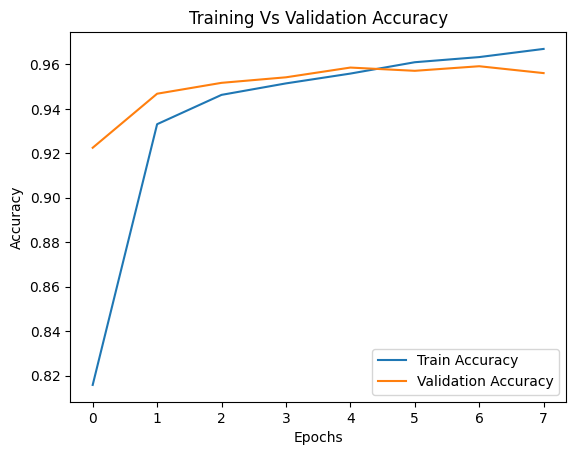

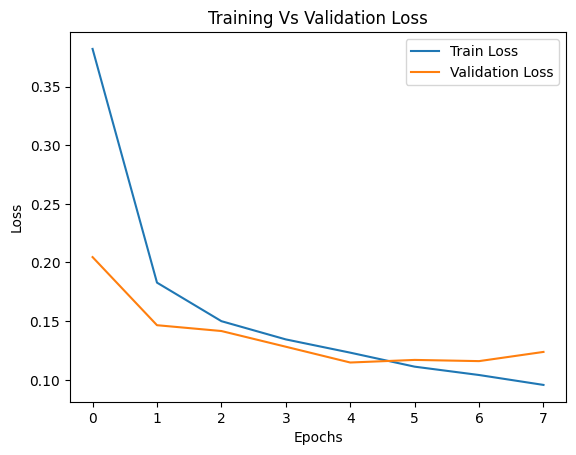

294/294 [==============================] - 22s 73ms/step
Classification Report:
              precision    recall  f1-score   support

      Female       0.95      0.96      0.95      4618
        Male       0.96      0.95      0.95      4784

    accuracy                           0.95      9402
   macro avg       0.95      0.95      0.95      9402
weighted avg       0.95      0.95      0.95      9402



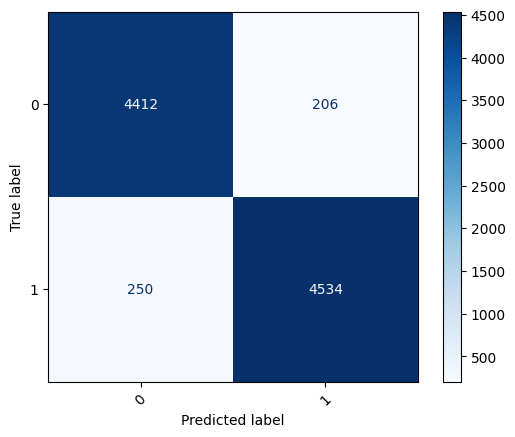

C:\Users\Mahmoud\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
dataset = np.array(train_dataset)
labels = np.array(train_labels)

model = train_vgg(dataset, labels, learning_rate=0.0001, batch_size=128, test_size=0.2, epochs=15, patience=3)
model.save('GENDER3.h5')